In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

sns.set(style="whitegrid")
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../reports/feature_plots', exist_ok=True)

In [2]:
train_raw = pd.read_csv('../data/raw/train.csv')
test_raw  = pd.read_csv('../data/raw/test.csv')

print(f"Train: {train_raw.shape} | Test: {test_raw.shape}")
train_raw.head()

Train: (891, 12) | Test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_raw['is_train'] = 1
test_raw['is_train']  = 0

full = pd.concat([train_raw, test_raw], sort=False)
print(f"Full dataset: {full.shape}")

Full dataset: (1309, 13)


In [4]:
print("Missing values before:")
print(full.isnull().sum()[full.isnull().sum() > 0])

Missing values before:
Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


In [5]:
full['Embarked'] = full['Embarked'].fillna(full['Embarked'].mode()[0])

In [6]:
median_fare = full.groupby('Pclass')['Fare'].median()
full['Fare'] = full.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))

In [7]:
full['Title'] = full['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

title_map = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
    'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
    'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs', 'Capt': 'Rare', 'Sir': 'Rare'
}
full['Title'] = full['Title'].map(title_map)

age_med = full.groupby(['Title', 'Pclass'])['Age'].median()
def impute_age(row):
    if pd.isnull(row['Age']):
        return age_med.get((row['Title'], row['Pclass']), full['Age'].median())
    return row['Age']

full['Age'] = full.apply(impute_age, axis=1)

In [8]:
full['HasCabin'] = full['Cabin'].notnull().astype(int)
full['Deck'] = full['Cabin'].str[0].fillna('Missing')

In [9]:
# Family size
full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full['IsAlone'] = (full['FamilySize'] == 1).astype(int)

# Fare per person
full['FarePerPerson'] = full['Fare'] / full['FamilySize']

# Age bins
full['AgeBin'] = pd.cut(full['Age'], bins=[0, 12, 18, 35, 60, 120], labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

# Fare log (reduce skew)
full['FareLog'] = np.log1p(full['Fare'])

In [10]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
full_clean = full.drop(columns=drop_cols)

In [11]:
train_clean = full_clean[full_clean['is_train'] == 1].drop(columns='is_train')
test_clean  = full_clean[full_clean['is_train'] == 0].drop(columns=['is_train', 'Survived'])

print(f"Train clean: {train_clean.shape} | Test clean: {test_clean.shape}")

Train clean: (891, 16) | Test clean: (418, 15)


In [12]:
print("Final features:")
print(train_clean.columns.tolist())

Final features:
['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'HasCabin', 'Deck', 'FamilySize', 'IsAlone', 'FarePerPerson', 'AgeBin', 'FareLog']


In [13]:
train_clean.to_csv('../data/processed/train_clean.csv', index=False)
test_clean.to_csv('../data/processed/test_clean.csv', index=False)
print("Clean data saved!")

Clean data saved!


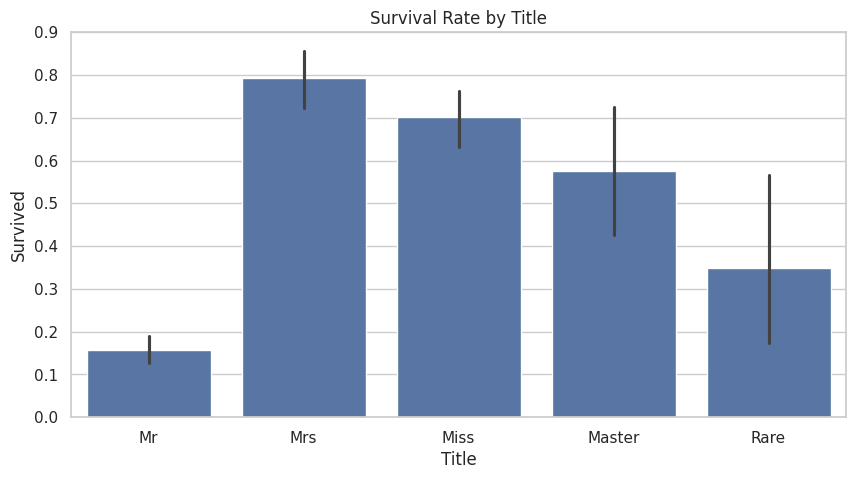

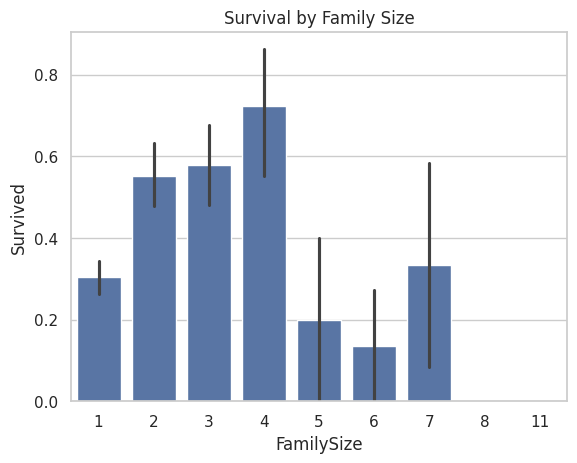

In [14]:
# Survival by Title
plt.figure(figsize=(10,5))
sns.barplot(x='Title', y='Survived', data=train_clean)
plt.title('Survival Rate by Title')
plt.savefig('../reports/feature_plots/survival_by_title.png', dpi=150, bbox_inches='tight')
plt.show()

# Survival by FamilySize
sns.barplot(x='FamilySize', y='Survived', data=train_clean)
plt.title('Survival by Family Size')
plt.show()